In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import time
import re

from bs4 import BeautifulSoup
import requests

In [2]:
url = 'https://www.sports-reference.com/cbb/postseason/men/2024-ncaa.html'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print(f"Failed to retrieve content, status code: {response.status_code}")

In [3]:
url = 'https://www.sports-reference.com/cbb/postseason/men/2024-ncaa.html'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print(f"Failed to retrieve content, status code: {response.status_code}")



# List of 64 teams in the playoffs
team_links = list(set([str(tag) for tag in soup.find_all('a') if tag.get('href') and '/cbb/schools/' in tag['href'] and tag['href'].endswith('/men/2024.html')]))
team_names= [BeautifulSoup(link, 'html.parser').get_text() for link in team_links]



# Parse HTML
base_url = "https://www.sports-reference.com"
urls = [base_url + BeautifulSoup(tag, "html.parser").a['href'] for tag in team_links]

df_list = []
counter = 0

for team, team_name in zip(urls, team_names):
    print('///// Currently parsing tables for : {} /////'.format(team.split('/')[5].upper()))
    print('\n')
    year = int(urls[0].split('/')[-1].split('.')[0])
    lookback_years = (lambda x: [x - i for i in range(15)])(year)


    for yr in lookback_years:

        new_team_url = (lambda url, year: re.sub(r'(\d{4})(\.html)$', str(year) + r'\2', url))(team, yr)
        print("Fetching data from {} ... ".format(yr))
        res = requests.get(url=new_team_url)
        time.sleep(3)
           
        if counter == 15:
            print('Reaching requests limit, resetting counter')
            time.sleep(60)
            counter = 0

        if res.status_code == 200:
            soup = BeautifulSoup(res.text, 'html.parser')
            table_container = soup.select_one('#div_per_game')
            per_game_table = table_container.find('table', id='per_game') if table_container else None
            
            if per_game_table:
                print('Successfully fetched {} table'.format(yr))
                print('Working URL {}'.format(new_team_url))
                data = pd.read_html(team)[5]
                data['Year'] = str(yr)
                data['Team'] = team_name
                df_list.append(data)
                counter += 1

            else:
                print("Failed to fetch data from {}".format(new_team_url))
                print('Dead URL {}'.format(new_team_url))

    print('\n')


final_df = pd.concat(df_list, ignore_index=True)

///// Currently parsing tables for : KENTUCKY /////


Fetching data from 2024 ... 
Successfully fetched 2024 table
Working URL https://www.sports-reference.com/cbb/schools/kentucky/men/2024.html
Fetching data from 2023 ... 
Successfully fetched 2023 table
Working URL https://www.sports-reference.com/cbb/schools/kentucky/men/2023.html
Fetching data from 2022 ... 
Successfully fetched 2022 table
Working URL https://www.sports-reference.com/cbb/schools/kentucky/men/2022.html
Fetching data from 2021 ... 
Successfully fetched 2021 table
Working URL https://www.sports-reference.com/cbb/schools/kentucky/men/2021.html
Fetching data from 2020 ... 
Successfully fetched 2020 table
Working URL https://www.sports-reference.com/cbb/schools/kentucky/men/2020.html
Fetching data from 2019 ... 
Successfully fetched 2019 table
Working URL https://www.sports-reference.com/cbb/schools/kentucky/men/2019.html
Fetching data from 2018 ... 
Successfully fetched 2018 table
Working URL https://www.sports-referenc

In [4]:
final_df.to_csv('per_game_data.csv')

### Analysis

In [8]:
df = pd.read_csv('per_game_data.csv').drop('Unnamed: 0', axis=1)
df['Team']

0                Kentucky
1                Kentucky
2                Kentucky
3                Kentucky
4                Kentucky
               ...       
13408    Western Kentucky
13409    Western Kentucky
13410    Western Kentucky
13411    Western Kentucky
13412    Western Kentucky
Name: Team, Length: 13413, dtype: object

In [23]:
df

,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,34,34,33.1,4.5,11.0,0.412,2.8,5.6,0.497,1.8,...,0.804,1.4,5.6,7.0,6.0,1.0,0.4,2.6,1.8,15.2
1,34,34,33.0,4.9,10.0,0.488,2.3,4.2,0.549,2.6,...,0.913,0.9,3.5,4.5,3.6,1.4,0.2,1.1,2.2,14.5
2,33,33,31.5,5.1,10.2,0.501,2.9,4.6,0.632,2.2,...,0.889,1.3,3.7,5.0,1.4,0.9,0.8,1.0,1.9,13.9
3,29,27,21.9,5.0,7.9,0.638,5.0,7.7,0.646,0.1,...,0.570,2.6,4.6,7.2,1.5,0.4,2.3,0.8,2.0,12.5
4,28,24,26.8,3.9,8.3,0.468,3.3,6.3,0.528,0.6,...,0.756,1.6,2.9,4.5,2.9,0.9,0.6,1.5,2.3,10.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12373,19,0,5.7,0.8,2.1,0.410,0.8,1.4,0.593,0.0,...,0.867,0.6,1.1,1.7,0.8,0.2,0.1,0.5,0.5,2.4
12374,18,0,3.8,0.4,0.8,0.467,0.3,0.5,0.667,0.1,...,0.667,0.1,0.1,0.2,0.6,0.4,0.0,0.2,0.3,0.9
12375,8,0,1.4,0.1,0.6,0.200,0.0,0.0,NaN,0.1,...,NaN,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.4
12376,10,0,1.5,0.2,0.4,0.500,0.2,0.4,0.500,0.0,...,0.000,0.1,0.3,0.4,0.0,0.0,0.0,0.0,0.6,0.4


In [182]:
correlation_matrix = df.corr()
target_correlation = correlation_matrix['PTS'].drop('PTS')  # Exclude self-correlation
top_correlated_features = target_correlation.abs().sort_values(ascending=False).head(25)
print(top_correlated_features)


FG     0.989866
FGA    0.980973
MP     0.920118
2PA    0.910918
FT     0.910708
FTA    0.889089
2P     0.882998
TOV    0.847132
GS     0.834106
DRB    0.820472
TRB    0.767487
STL    0.725164
3PA    0.711356
3P     0.710615
PF     0.709519
AST    0.694419
G      0.647062
ORB    0.528677
BLK    0.439554
FT%    0.349618
3P%    0.259315
FG%    0.237113
2P%    0.130257
Name: PTS, dtype: float64


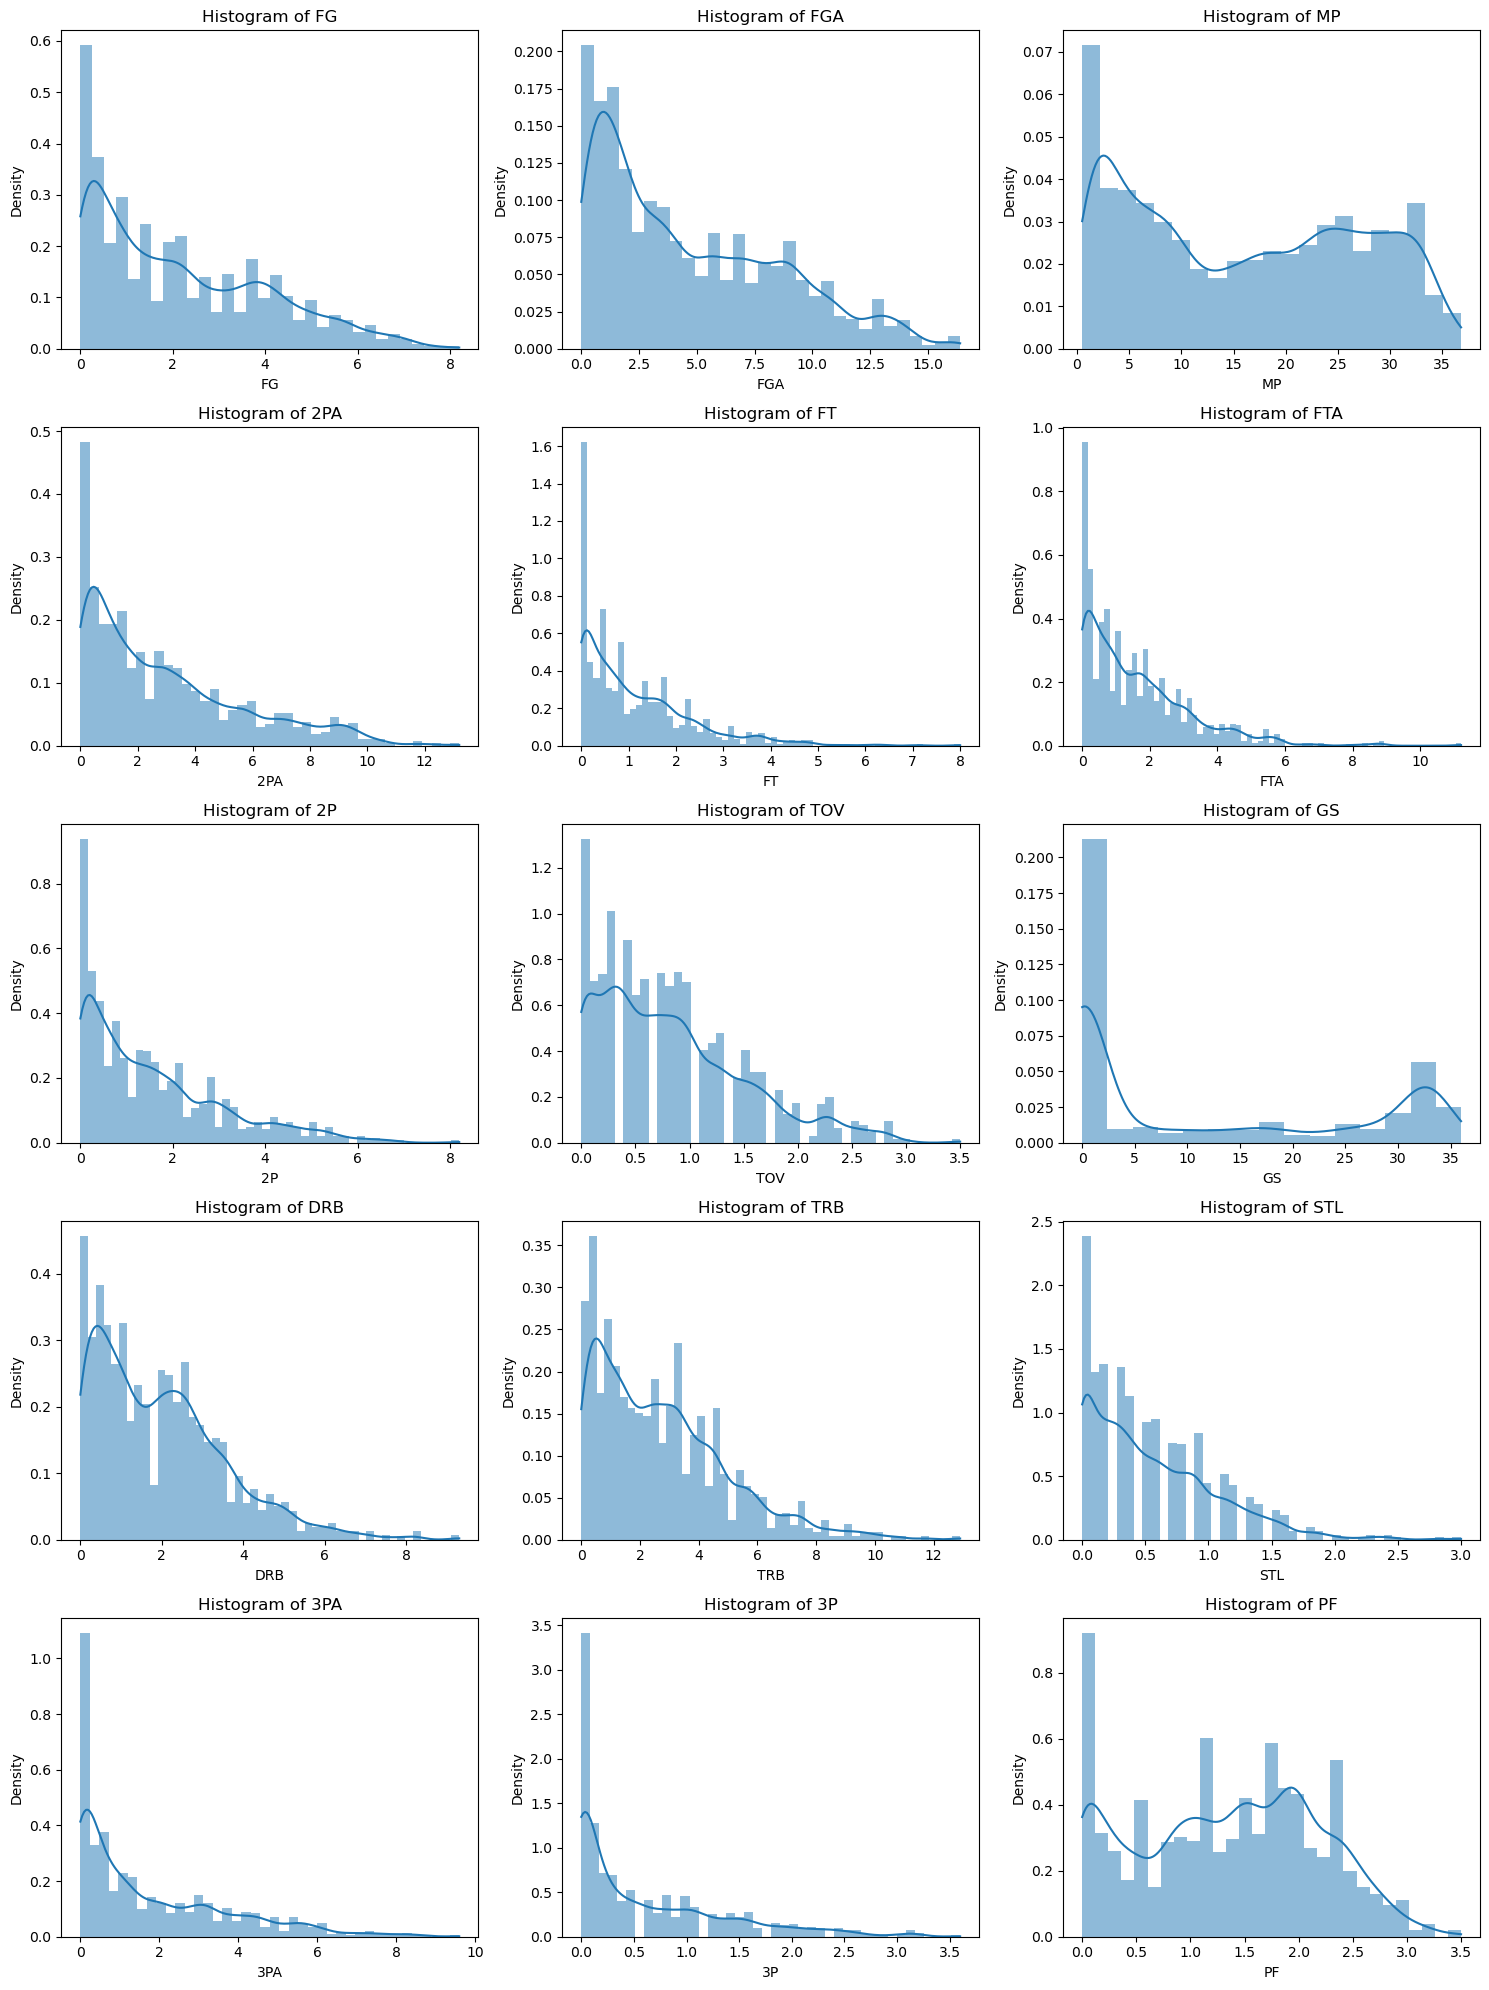

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

top_15_features = top_correlated_features.head(15).index.tolist()

# Setting up the figure and axes for a 5x3 subplot grid
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.tight_layout(pad=5.0)

# Iterating over each feature and its respective position in the grid
for i, feature in enumerate(top_15_features):
    row, col = divmod(i, 3)
    sns.histplot(df[feature], kde=True, stat="density", linewidth=0, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


<Axes: xlabel='PTS', ylabel='Density'>

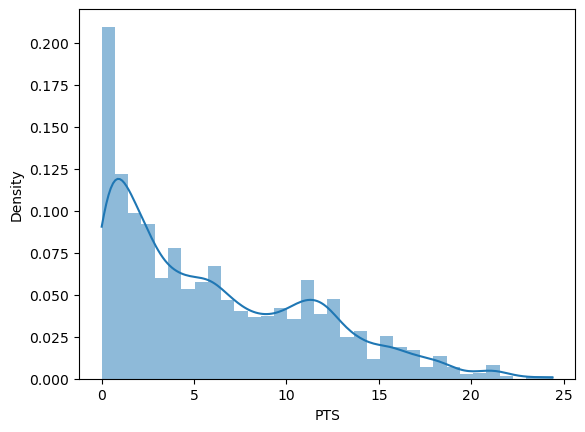

In [28]:
sns.histplot(df['PTS'], kde=True, stat="density", linewidth=0)


In [103]:
X.iloc[:,:3]

,FG,FGA,MP
0,4.5,11.0,33.1
1,4.9,10.0,33.0
2,5.1,10.2,31.5
3,5.0,7.9,21.9
4,3.9,8.3,26.8
...,...,...,...
12373,0.8,2.1,5.7
12374,0.4,0.8,3.8
12375,0.1,0.6,1.4
12376,0.2,0.4,1.5


In [128]:
X = df[top_15_features].iloc[:,:3]
y = df['PTS']

with pm.Model() as bayesian_linear_regression:

    # Store data
    x_data = pm.MutableData("X", X)
    y_data = pm.MutableData("y", y)

    # Priors for the regression coefficients
    beta_FG = pm.LogNormal('beta_FG', mu=0, sigma=1)
    beta_FGA = pm.LogNormal('beta_FGA', mu=0, sigma=1)
    beta_MP = pm.Exponential('beta_MP', lam=1)
    # beta_2PA = pm.LogNormal('beta_2PA', mu=0, sigma=1)
    # beta_FT = pm.LogNormal('beta_FT', mu=0, sigma=1)
    # beta_FTA = pm.LogNormal('beta_FTA', mu=0, sigma=1)
    # beta_2P = pm.LogNormal('beta_2P', mu=0, sigma=1)
    # beta_TOV = pm.LogNormal('beta_TOV', mu=0, sigma=1)
    # beta_GS = pm.Exponential('beta_GS', 1)
    # beta_DRB =  pm.Normal('beta_DRB', mu=0, sigma=1)
    # beta_TRB = pm.Normal('beta_TRB', mu=0, sigma=1)
    # beta_STL = pm.Exponential('beta_STL', 1)
    # beta_3PA = pm.Normal('beta_3PA', mu=0, sigma=1)
    # beta_3P = pm.Normal('beta_3P', mu=0, sigma=1)
    # beta_PF =  pm.Normal('beta_PF', mu=0, sigma=1)

    # beta_vector = pm.math.stack([beta_FG, beta_FGA, beta_MP, beta_2PA, beta_FT, beta_FTA, beta_2P, beta_TOV, beta_GS, beta_DRB, beta_TRB, beta_STL, beta_3PA, beta_3P, beta_PF])
    beta_vector = pm.math.stack([beta_FG, beta_FGA, beta_MP])

    # Model error prior
    sigma = pm.HalfCauchy('sigma', beta=10)

    # Expected value (linear model)
    mu = pm.math.dot(X, beta_vector)

    # Likelihood of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_FG, beta_FGA, beta_MP, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 31 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


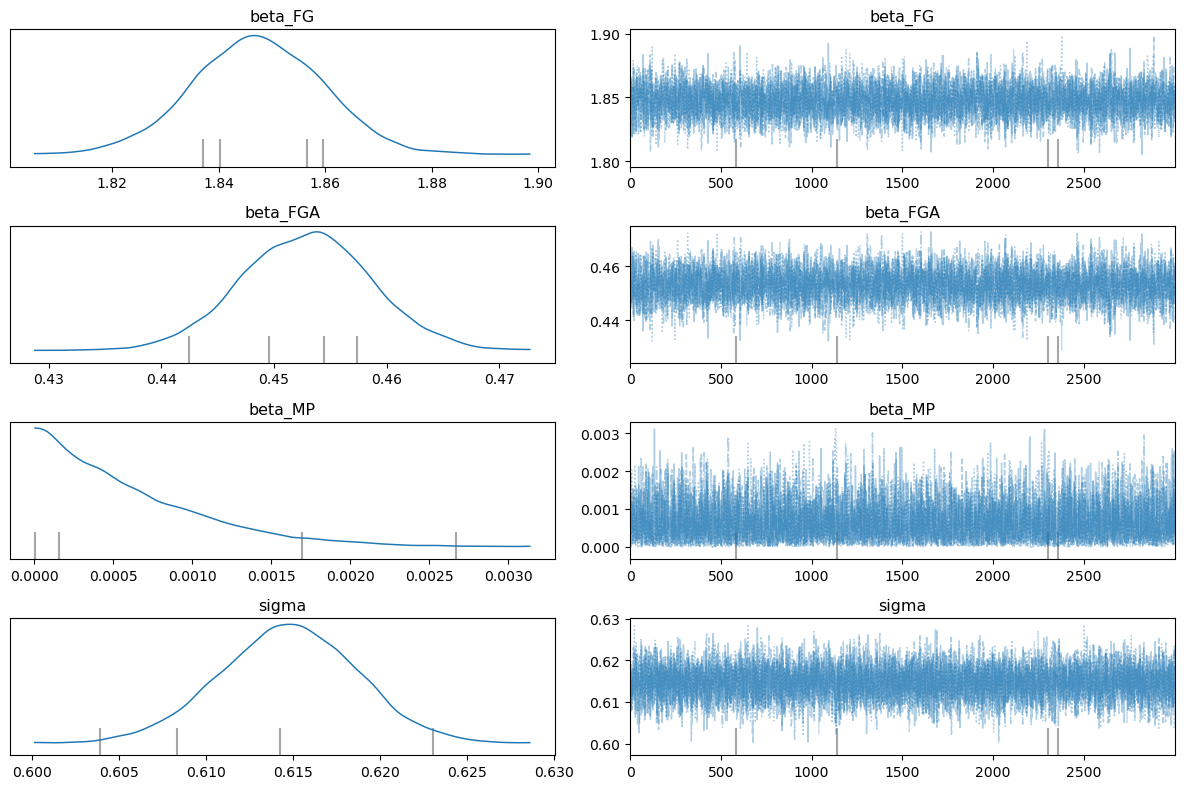

In [129]:
import arviz as az
az.plot_trace(trace, combined=True);
plt.tight_layout()

In [174]:
X_new = np.random.randn(10, 3)  # 10 new samples, replace with actual data
X_new

array([[-1.73938992,  0.05793339, -0.2876494 ],
       [-0.12982039, -0.1853707 ,  1.38579387],
       [-0.44943037, -1.3666165 ,  0.10728652],
       [ 1.36863634, -0.84295857, -1.01138761],
       [-0.48191853,  0.39670136, -1.1287613 ],
       [-0.44893552, -0.89507734, -0.73662575],
       [ 0.245806  , -0.84784285,  1.44223546],
       [ 0.59845317,  0.65163926,  0.65873877],
       [ 0.41197624, -1.12398548,  1.20139244],
       [-0.61158192,  0.32581577,  2.05116966]])

In [175]:
# Predictions
with bayesian_linear_regression:
    pm.set_data({"X": X_new})
    predictions = pm.sample_posterior_predictive(trace, predictions=True).predictions

Sampling: [y_obs]


In [180]:
predictions['y_obs'].shape

(4, 3000, 12378)

In [181]:
with pm.Model(coords_mutable={"trial": [0, 1, 2]}) as model:
    x = pm.MutableData("x", [-1, 0, 1], dims=["trial"])
    beta = pm.Normal("beta")
    noise = pm.HalfNormal("noise")
    y = pm.Normal("y", mu=x * beta, sigma=noise, observed=[-2, 0, 3], dims=["trial"])

    idata = pm.sample()
    # in-sample predictions
    posterior_predictive = pm.sample_posterior_predictive(idata).posterior_predictive

with model:
    pm.set_data({"x": [-2, 2]}, coords={"trial": [3, 4]})
    # out-of-sample predictions
    predictions = pm.sample_posterior_predictive(idata, predictions=True).predictions

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Sampling: [y]


In [173]:
predictions['y']

<xarray.DataArray 'y' (chain: 4, draw: 1000, trial: 2)>
array([[[-1.10953907,  4.96847678],
        [ 0.3054207 ,  1.60293099],
        [-1.85505107, -0.35941623],
        ...,
        [-4.10419124,  4.19182098],
        [-5.48584198,  3.75276625],
        [-7.41039831,  3.53122298]],

       [[-4.1945206 ,  4.79134861],
        [-4.58885139,  4.57226622],
        [-2.20712364,  1.47282565],
        ...,
        [-3.4128198 ,  4.36464554],
        [-2.79497486,  4.24609432],
        [-4.0894076 ,  2.38522599]],

       [[-4.07197113,  7.12135769],
        [-3.11986327,  3.38614718],
        [-4.30170302,  2.95001224],
        ...,
        [ 1.27398707,  4.03869272],
        [-3.44159865,  2.82052145],
        [-0.39040177,  1.67084149]],

       [[-3.26258802,  3.97197403],
        [-2.90969893, -1.552975  ],
        [-4.07260945,  4.33204672],
        ...,
        [-6.16413319,  4.97109815],
        [-4.03318198,  2.67908105],
        [-2.20063242,  2.08578815]]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * trial    (trial) int32 3 4